Defaulting to user installation because normal site-packages is not writeable
Fitting 10 folds for each of 19683 candidates, totalling 196830 fits
Grid search running time: 1339.65 seconds
Best parameters: {'colsample_bytree': 0.8, 'gamma': 1.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1.5, 'subsample': 0.6}
Best score: 0.7010601265822783
Total running time (including feature importance plotting): 1339.75 seconds


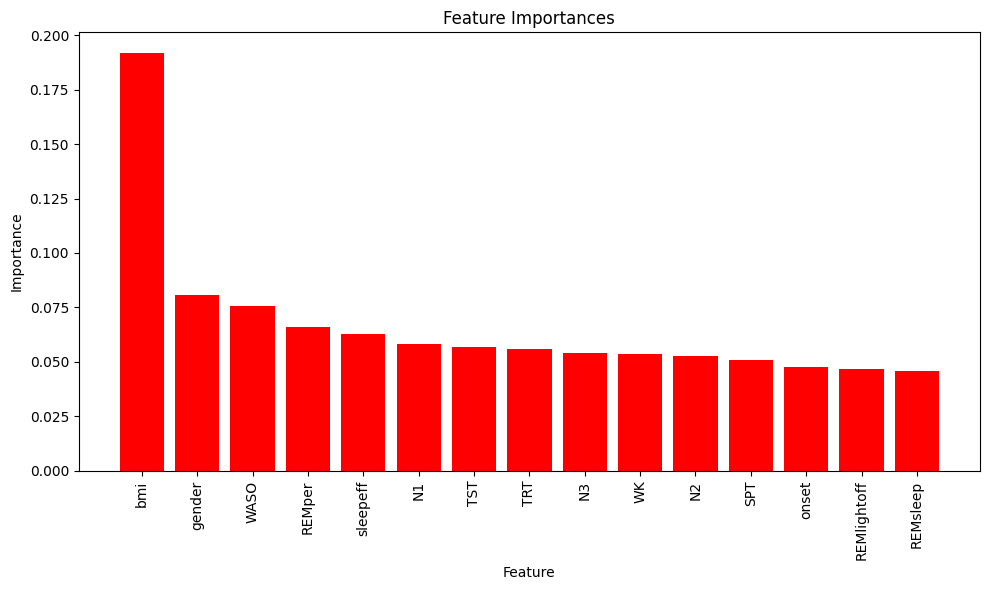

['xgboost_model.joblib']

In [2]:
!pip install joblib
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Assuming 'data' is a pandas DataFrame

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from joblib import dump  # Used to save the model to a file

# read data
try:
    # Attempt to load the file using the Python engine
    data = pd.read_csv('newdata.csv')

    # Create a new column 'severity' based on the 'ahi' column
    conditions = [
        (data['ahi'] < 5),
        (data['ahi'] >= 5)
        
    ]
    choices = ['Normal', 'Not normal']
    data['severity'] = np.select(conditions, choices, default='Not Available')

    # Display the first few rows to verify the new column
    result = data.head()
except Exception as e:
    result = f"An error occurred: {e}"

# Convert categorical columns to numeric if necessary
for col in ['gender', 'Status', 'osasev']:  # Add other categorical columns here
    if data[col].dtype == 'object':
        data[col] = LabelEncoder().fit_transform(data[col])

# Fill missing values for numerical and categorical columns
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col].fillna(data[col].mean(), inplace=True)
    elif data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)

# Split the data into features and target
X = data.drop(['tst_rem', 'tst_nrem', 'Status', 'osasev', 'ahi', 'remahi', 'nremahi', 'weight', 'age', 'height', 'severity'], axis=1)
y = LabelEncoder().fit_transform(data['severity'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize timer
start_time = time.time()

# Define the model
model = XGBClassifier()

# Set up the grid search with cross-validation
grid_cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_cv.fit(X_train, y_train)

# Calculate and print the running time for the grid search
grid_search_time = time.time() - start_time
print(f"Grid search running time: {grid_search_time:.2f} seconds")

# Get the best parameters and the best score
best_params = grid_cv.best_params_
best_score = grid_cv.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

# Retrieve the best model
best_model = grid_cv.best_estimator_

# Get feature importances
importances = best_model.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels

# Stop the timer for the total running time and print it
total_running_time = time.time() - start_time
print(f"Total running time (including feature importance plotting): {total_running_time:.2f} seconds")

plt.show()

# Save the model to a file
dump(best_model, 'xgboost_model.joblib')



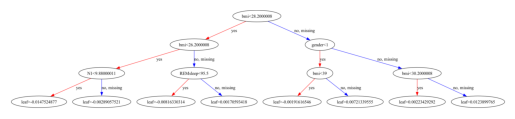

In [3]:
import xgboost as xgb
# import matplotlib.pyplot as plt

# Assuming 'best_model' is your trained XGBClassifier with the best parameters from GridSearchCV

# Plot the first tree from the model
xgb.plot_tree(best_model, num_trees=0)

plt.show()

# If you want to plot a specific tree, you can change the num_trees value to the desired tree number.
# For example, to plot the second tree, you would use num_trees=1, as indexing starts at 0.

In [9]:
# Print the first tree in text format
print(xgb.to_graphviz(best_model, num_trees=0, rankdir='LR'))


digraph {
    graph [ rankdir=TB ]
    graph [ rankdir="LR" ]

    0 [ label="bmi<28.2000008" ]
    0 -> 1 [label="yes" color="#FF0000"]
    0 -> 2 [label="no, missing" color="#0000FF"]

    1 [ label="bmi<26.2000008" ]
    1 -> 3 [label="yes" color="#FF0000"]
    1 -> 4 [label="no, missing" color="#0000FF"]

    3 [ label="N1<9.88000011" ]
    3 -> 7 [label="yes" color="#FF0000"]
    3 -> 8 [label="no, missing" color="#0000FF"]

    7 [ label="leaf=-0.0147524877" ]

    8 [ label="leaf=-0.00289057521" ]

    4 [ label="REMsleep<95.5" ]
    4 -> 9 [label="yes" color="#FF0000"]
    4 -> 10 [label="no, missing" color="#0000FF"]

    9 [ label="leaf=-0.00816330314" ]

    10 [ label="leaf=0.00170593418" ]

    2 [ label="gender<1" ]
    2 -> 5 [label="yes" color="#FF0000"]
    2 -> 6 [label="no, missing" color="#0000FF"]

    5 [ label="bmi<39" ]
    5 -> 11 [label="yes" color="#FF0000"]
    5 -> 12 [label="no, missing" color="#0000FF"]

    11 [ label="leaf=-0.00191616546" ]

    12 [ la

In [4]:
# Export the model to a JSON string
model_json = best_model.get_booster().get_dump(dump_format='json')
# The model's trees are stored in a list, so you can access individual trees
first_tree_json = model_json[0]
print(first_tree_json)


  { "nodeid": 0, "depth": 0, "split": "bmi", "split_condition": 28.2000008, "yes": 1, "no": 2, "missing": 2 , "children": [
    { "nodeid": 1, "depth": 1, "split": "bmi", "split_condition": 26.2000008, "yes": 3, "no": 4, "missing": 4 , "children": [
      { "nodeid": 3, "depth": 2, "split": "N1", "split_condition": 9.88000011, "yes": 7, "no": 8, "missing": 8 , "children": [
        { "nodeid": 7, "leaf": -0.0147524877 }, 
        { "nodeid": 8, "leaf": -0.00289057521 }
      ]}, 
      { "nodeid": 4, "depth": 2, "split": "REMsleep", "split_condition": 95.5, "yes": 9, "no": 10, "missing": 10 , "children": [
        { "nodeid": 9, "leaf": -0.00816330314 }, 
        { "nodeid": 10, "leaf": 0.00170593418 }
      ]}
    ]}, 
    { "nodeid": 2, "depth": 1, "split": "gender", "split_condition": 1, "yes": 5, "no": 6, "missing": 6 , "children": [
      { "nodeid": 5, "depth": 2, "split": "bmi", "split_condition": 39, "yes": 11, "no": 12, "missing": 12 , "children": [
        { "nodeid": 11, "le

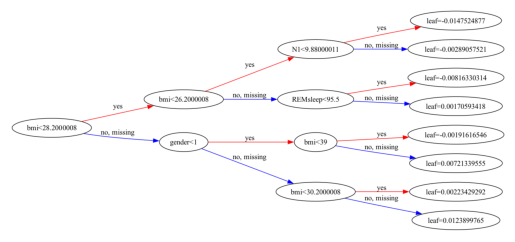

In [3]:

import xgboost as xgb
import matplotlib.pyplot as plt
from joblib import load

# Load the model from the file
best_model = load('xgboost_model.joblib')
# Assuming 'best_model' is your trained XGBClassifier with the best parameters from GridSearchCV

# Generate the plot
g = xgb.to_graphviz(best_model, num_trees=2, rankdir='LR')

# Render and show the plot
g.render('output_tree2', format='png', cleanup=True)  # Saves the plot to a file 'output_tree.png'
img = plt.imread('output_tree.png')
plt.imshow(img)
plt.axis('off')  # Do not show axes for image plot
plt.show()
